In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
imgs_dir = "SAVERA_FIXED_DATA/ROOFs/"
masks_dir = "SAVERA_FIXED_DATA/MASKs/"

### Get input images and their masks together

In [3]:
imgs_paths = os.listdir(imgs_dir)
mask_paths = os.listdir(masks_dir)
        
print("\nTotal {} image paths found!".format(len(imgs_paths)))
print("Total {} mask paths found!\n".format(len(mask_paths)))

# Make pair of image and its masks
img_mask_paths_pair = {}
image_counter = 0

for imgpath, maskpath in zip(imgs_paths, mask_paths):
    if (imgpath.split('_')[-1] == maskpath.split('_')[-1]):
        imgfullpath = os.path.join(imgs_dir, imgpath)
        maskfullpath = os.path.join(masks_dir, maskpath)
        img_mask_paths_pair[imgfullpath] = maskfullpath

print("Total {} image-mask pairs".format(len(img_mask_paths_pair)))


Total 597 image paths found!
Total 597 mask paths found!

Total 597 image-mask pairs


In [4]:
def load_data(paths_dict, outshape=(256, 256)):
    """
    paths_dict: Python Dictionary contains image path as key and list of mask paths as value.
    batchsize: number of images and masks in a batch
    outshape: shape of the images and masks. Default is 256 for U-net model
    """
    img_batch = []
    mask_batch = []
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
#     kernel = np.array(([-2, -2, -2], [-2, 17, -2], [-2, -2, -2]), dtype='int')
    for imgpath in paths_dict.keys():
        # Image
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.filter2D(img, -1, kernel) # image sharpening
        img = cv2.bilateralFilter(img, 3, 75, 75)
        img = cv2.resize(img, outshape) / 255 # Normalize image
        # Mask
        mask = cv2.imread(paths_dict[imgpath], 0)
        mask = cv2.resize(mask, outshape)
        mask = np.expand_dims(mask, -1) / 255 # Normalize image
            
        img_batch.append(img[np.newaxis, ...])
        mask_batch.append(mask[np.newaxis, ...])
    return np.concatenate(img_batch, axis=0), np.concatenate(mask_batch, axis=0)


In [5]:
# PARAMETERS
BATCHSIZE = 8
MODEL_INPUT_SHAPE = (256, 256)

### Train-Val split

In [6]:
train_size = .90
train_paths = dict(list(img_mask_paths_pair.items())[:int(len(img_mask_paths_pair)*train_size)])
val_paths = dict(list(img_mask_paths_pair.items())[int(len(img_mask_paths_pair)*train_size):-10])
test_paths = dict(list(img_mask_paths_pair.items())[-10:])
                   
print("Train images:", len(train_paths))
print("Validation images:", len(val_paths))
print("Test images:", len(test_paths))

def get_data_batch(paths_dict, batchsize=8):
    _from = 0
    _to = _from + batchsize
    while True:
        if _to > len(paths_dict):
            tmp_dict1 = dict(list(paths_dict.items())[_from:])
            rem = abs(batchsize - len(tmp_dict1))
            tmp_dict2 = dict(list(paths_dict.items())[:rem])
            rem_dict = {**tmp_dict1, **tmp_dict2}
            _from = rem
            _to = _from + batchsize
#             print("last batch:", _from, len(paths_list))
            yield load_data(dict(list(rem_dict.items())))
        else:
#             print(_from, _to)
            yield  load_data(dict(list(paths_dict.items())[_from:_to]))
            _from = _to
            _to = _to + batchsize
test_paths

Train images: 537
Validation images: 50
Test images: 10


{'SAVERA_FIXED_DATA/ROOFs/SVRROOF_90.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_90.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_91.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_91.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_92.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_92.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_93.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_93.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_94.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_94.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_95.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_95.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_96.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_96.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_97.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_97.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_98.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_98.png',
 'SAVERA_FIXED_DATA/ROOFs/SVRROOF_99.png': 'SAVERA_FIXED_DATA/MASKs/SVRMASK_99.png'}

### Visualization

Batch: (16, 256, 256, 3) (16, 256, 256, 1)


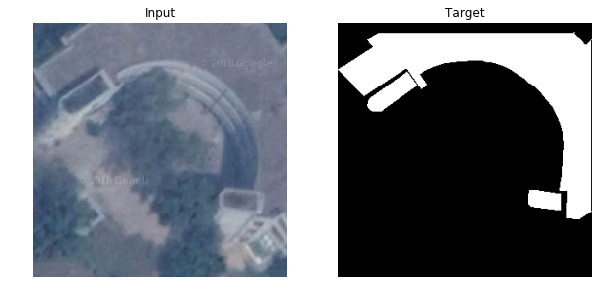

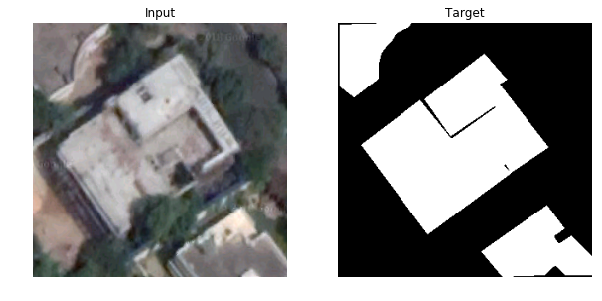

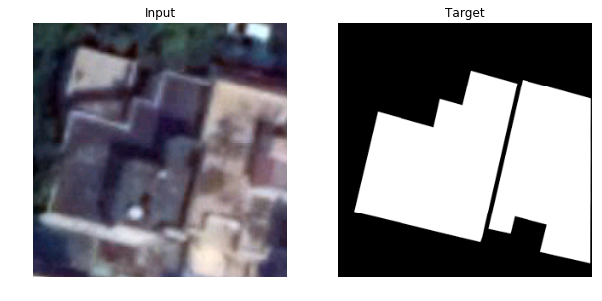

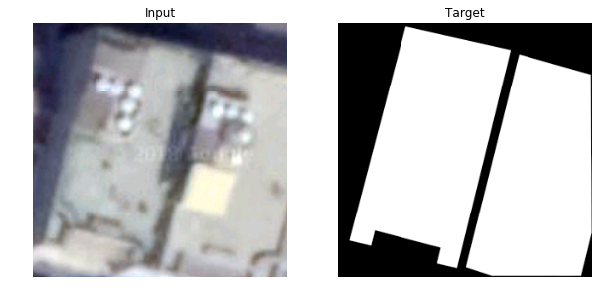

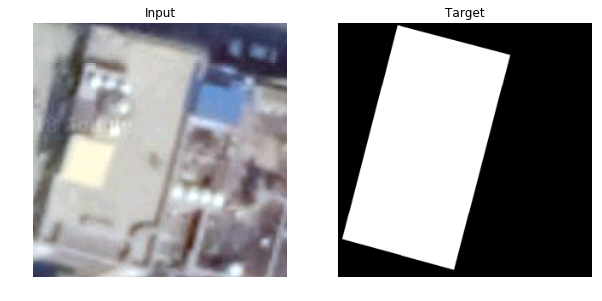

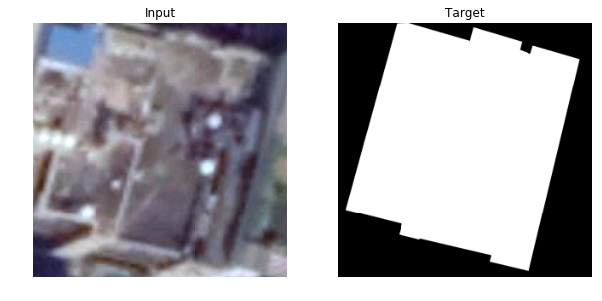

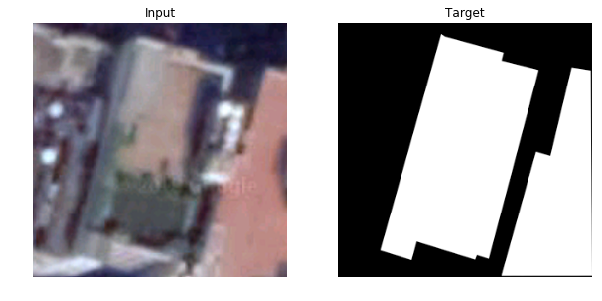

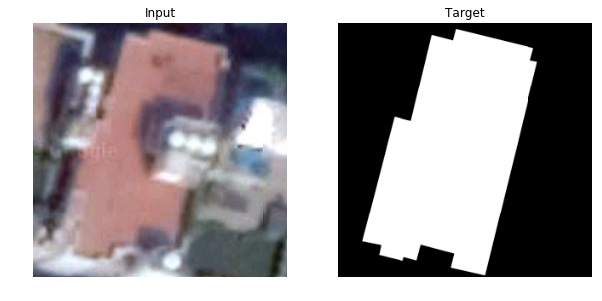

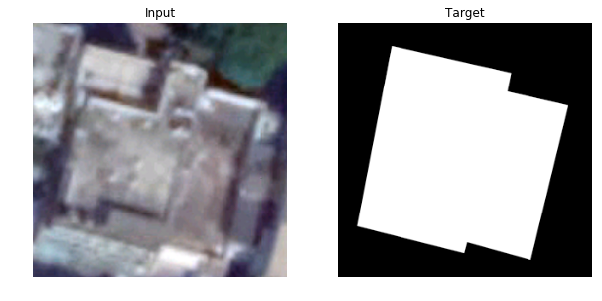

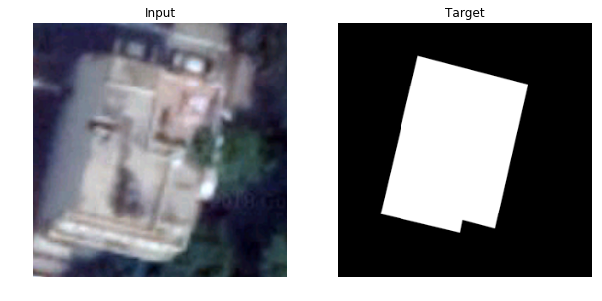

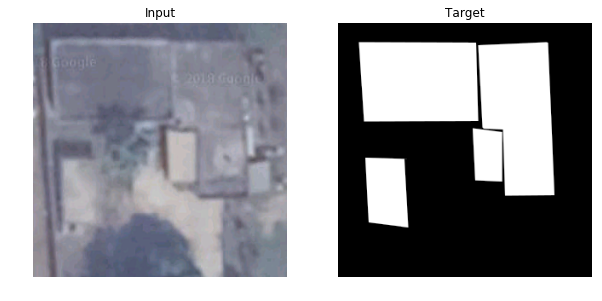

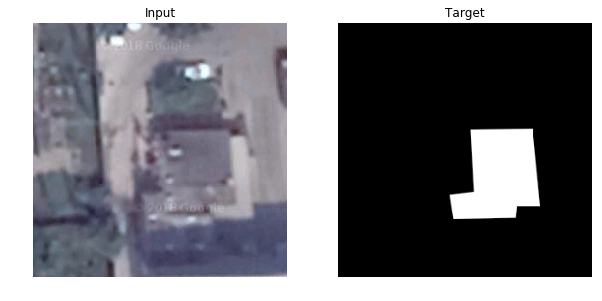

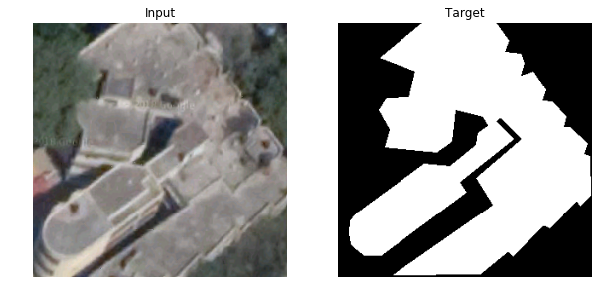

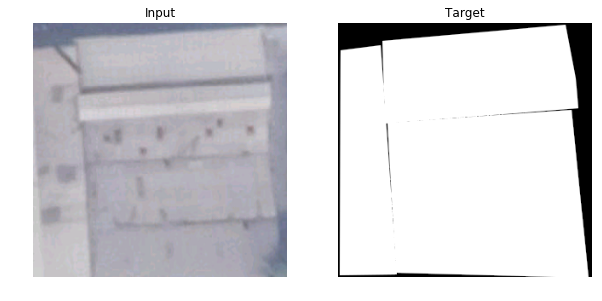

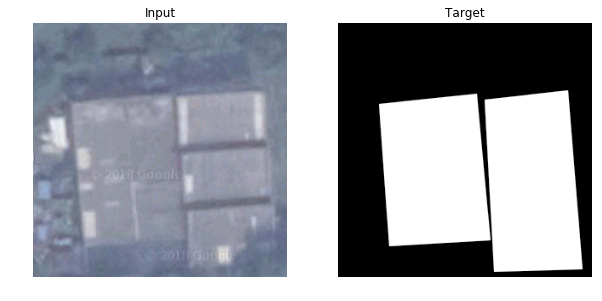

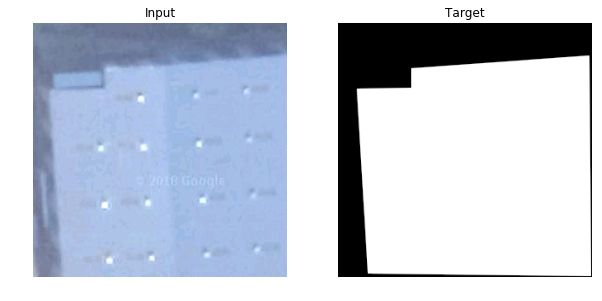

In [7]:
imgs, masks = next(get_data_batch(train_paths, batchsize=16))
print("Batch:", imgs.shape, masks.shape)
for i, (img, mask) in enumerate(zip(imgs, masks)):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Input')
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Target')
    plt.imshow(mask.reshape(MODEL_INPUT_SHAPE), cmap='gray')
    plt.show()

### Data Augmentation

In [8]:
from tensorflow.keras.preprocessing import image as Kimage

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=45.,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
                     zoom_range=0.2,
                    )
image_datagen = Kimage.ImageDataGenerator(**data_gen_args)
mask_datagen = Kimage.ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

# INITIATE DATA GENERATORS
traingen = get_data_batch(train_paths, BATCHSIZE)
valgen = get_data_batch(val_paths, BATCHSIZE)

def trainAugm():
    for i, (trainimgs, trainmasks) in enumerate(traingen):
#         print('data batch:',i)
        for j in range(BATCHSIZE//2):
#             print('flow batch:', j)
            image_datagen.fit(trainimgs, augment=True, seed=seed)
            mask_datagen.fit(trainmasks, augment=True, seed=seed)
            image_generator = image_datagen.flow(trainimgs, 
                                                 batch_size=BATCHSIZE,
#                                                  save_to_dir='kerasGeneratedImages',
#                                                  save_prefix='KGI',
                                                 seed=seed)
            mask_generator = mask_datagen.flow(trainmasks,
                                               batch_size=BATCHSIZE,
#                                                save_to_dir='kerasGeneratedMasks',
#                                                save_prefix='KGM',
                                               seed=seed)
            
            yield next(zip(image_generator, mask_generator))

## Model

In [9]:
from u_net import get_unet_256
# from custom_losses_and_metrics import bce_dice_loss, dice_coeff
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
                  
## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

model = get_unet_256()
# model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_name = 'SAVERA_597'
save_dir = '{}_chkpt'.format(model_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
weight_path="{}/{}_weights.best.hdf5".format(save_dir, model_name)
checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True
                            )
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.2,
                                   patience=1, 
                                   verbose=1, 
                                   mode='min',
                                   min_delta=0.0001, 
                                   cooldown=0, 
                                   min_lr=1e-8
                                  )
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose=2,
                      patience=20 # probably needs to be more patient
                     )

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [13]:
# LOAD CHECKPOINT (IF ANY)
try:
    model.load_weights(weight_path)
    print("CheckPoint loaded!")
except:
    print("No CheckPoint found.")
    pass

No CheckPoint found.


In [14]:
# START TRAINING
history = model.fit_generator(
    generator=trainAugm(),
    steps_per_epoch=len(train_paths)//(BATCHSIZE//2),
    validation_data=valgen,
    validation_steps=len(val_paths)//BATCHSIZE,
    epochs=50,
    callbacks=callbacks_list
)

Epoch 1/50


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [13]:
# SAVE MODEL
model.save('{}/{}_trained_full_model.h5'.format(save_dir, model_name))

In [14]:
# from tensorflow.keras.models import load_model
# # # LOAD MODEL
# # # model = load_model('{}/{}_trained_full_model.h5'.format(save_dir, model_name), custom_objects={
# # #     'bce_dice_loss':bce_dice_loss,
# # #     'dice_coeff':dice_coeff
# # # })
# model = load_model('{}/{}_trained_full_model.h5'.format(save_dir, model_name), custom_objects={
#     'IoU':IoU,
# })
# # model = load_model('{}/{}_trained_full_model.h5'.format(save_dir, model_name))

### Traning quality

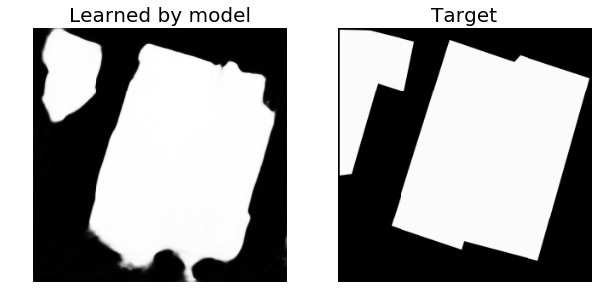

In [15]:
img_no = 2
imgs, masks, next(get_data_batch(train_paths))
testimg = imgs[img_no].reshape(1, 256, 256, 3)
targetmask = masks[img_no].reshape(MODEL_INPUT_SHAPE)
pred = model.predict(testimg)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Learned by model', fontsize=20)
plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target', fontsize=20)
plt.imshow(targetmask, cmap='gray')
plt.show()

### Validation

Batch: (8, 256, 256, 3) (8, 256, 256, 1)


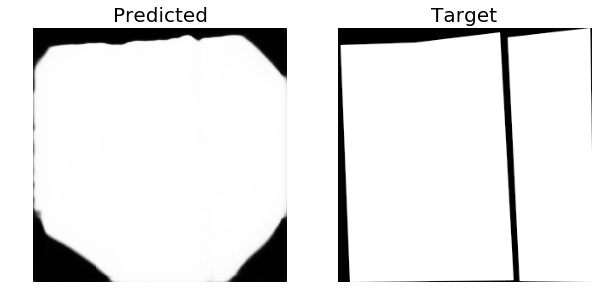

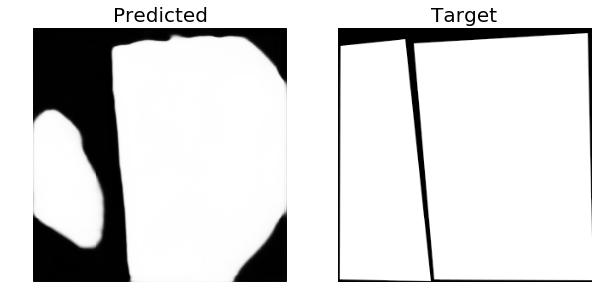

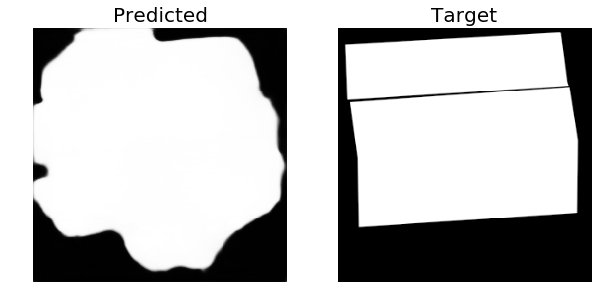

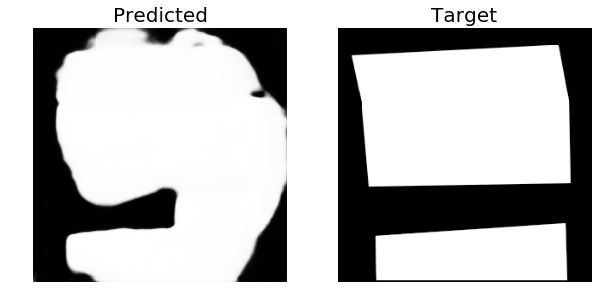

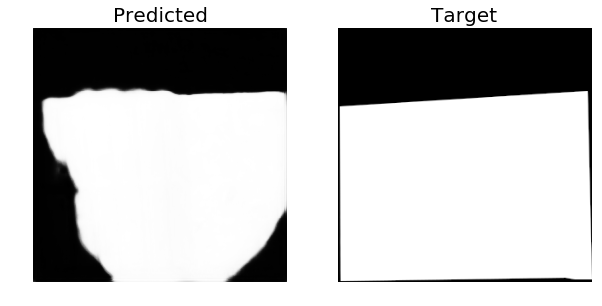

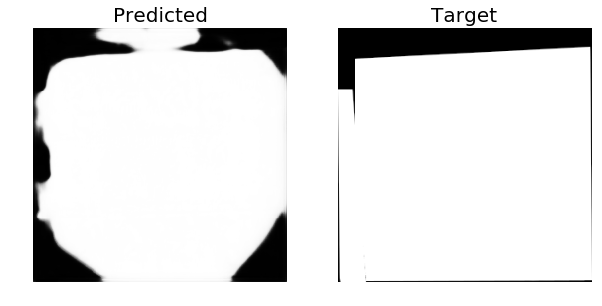

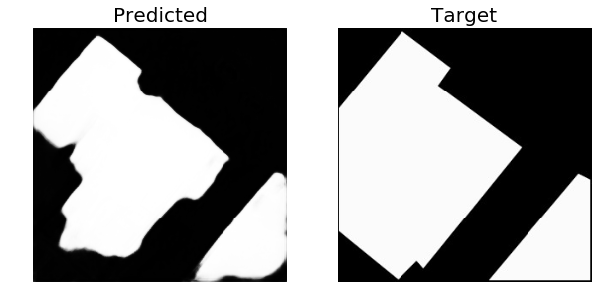

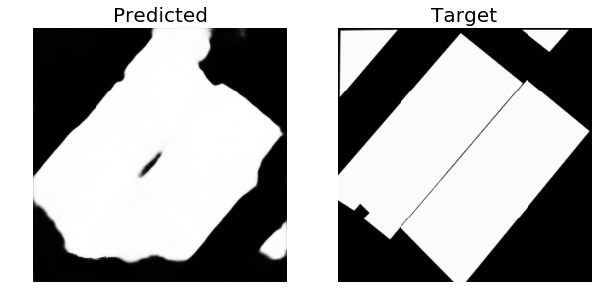

In [16]:
imgs, masks = next(get_data_batch(val_paths))
print("Batch:", imgs.shape, masks.shape)
for img, mask in zip(imgs, masks):
    testimg = img.reshape(1, 256, 256, 3)
    targetmask = mask.reshape(MODEL_INPUT_SHAPE)
    pred = model.predict(testimg)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Predicted', fontsize=20)
    plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Target', fontsize=20)
    plt.imshow(targetmask, cmap='gray')
    plt.show()

### TEST

Batch: (10, 256, 256, 3) (10, 256, 256, 1)


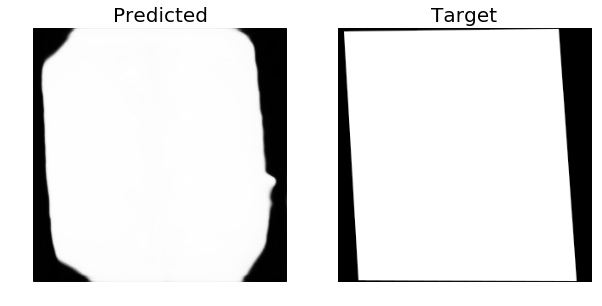

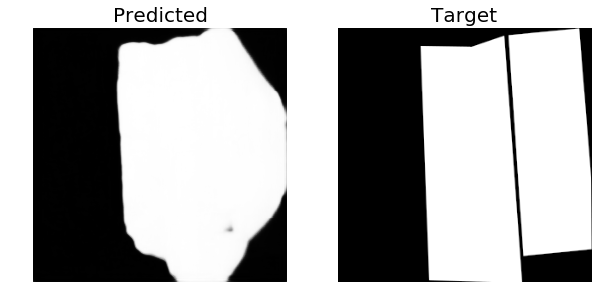

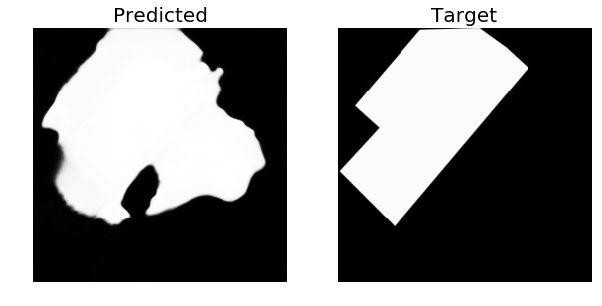

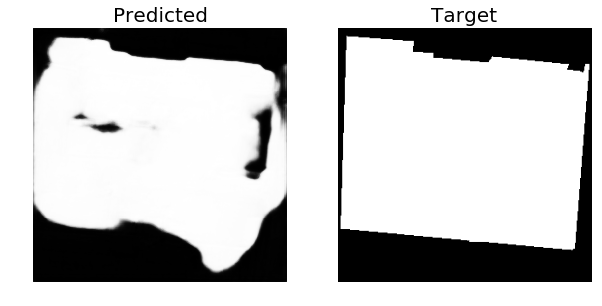

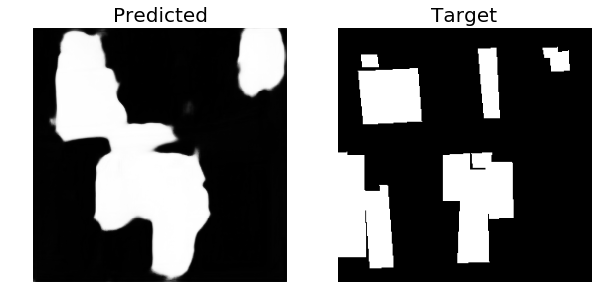

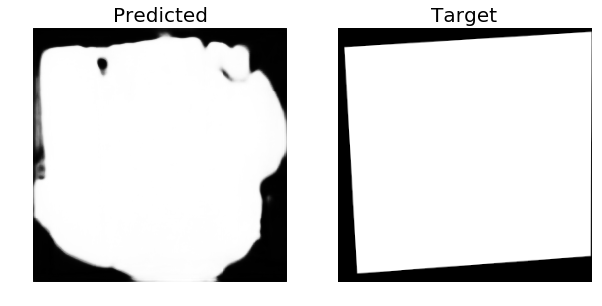

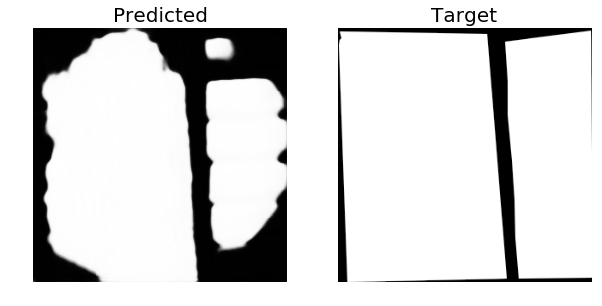

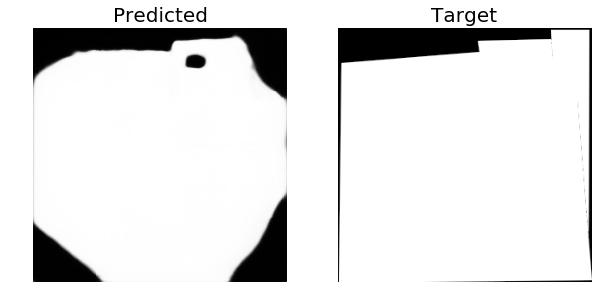

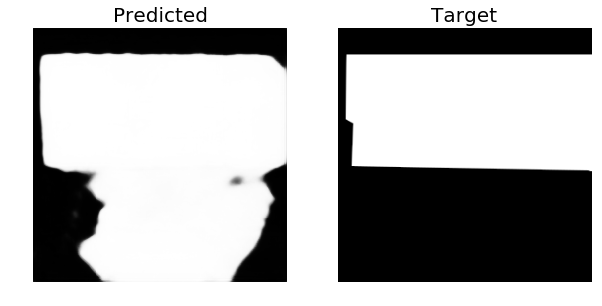

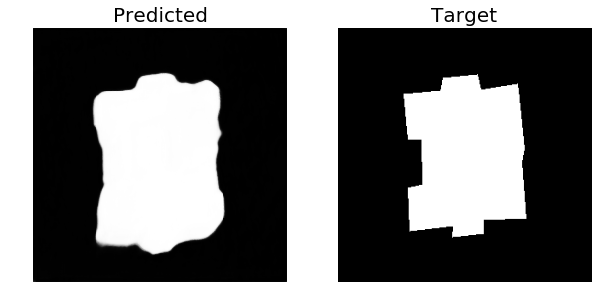

In [17]:
imgs, masks = next(get_data_batch(test_paths, batchsize=len(test_paths)))
print("Batch:", imgs.shape, masks.shape)
for img, mask in zip(imgs, masks):
    testimg = img.reshape(1, 256, 256, 3)
    targetmask = mask.reshape(MODEL_INPUT_SHAPE)
    pred = model.predict(testimg)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Predicted', fontsize=20)
    plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Target', fontsize=20)
    plt.imshow(targetmask, cmap='gray')
    plt.show()